In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip '/content/gdrive/MyDrive/Colab Notebooks/Chocolate.zip' > /dev/null

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('Training on CPU.')
else:
  print('Training on GPU.')

Training on GPU.


In [4]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [5]:
directory = 'Chocolate'

batchSize = 20

# define transforms
# training (with random flips and rotation)
trainTransform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(), transforms.RandomRotation(70), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# validation and testing
transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# choose the training, validation and test datasets
trainData = datasets.ImageFolder(directory + '/train', transform=trainTransform)
valData = datasets.ImageFolder(directory + '/val', transform=transform)
testData = datasets.ImageFolder(directory + '/test', transform=transform)

# prepare the data loaders
trainLoader = torch.utils.data.DataLoader(trainData, batchSize, shuffle=True)
valLoader = torch.utils.data.DataLoader(valData, batchSize, shuffle=True)
testLoader = torch.utils.data.DataLoader(testData, batchSize, shuffle=True)

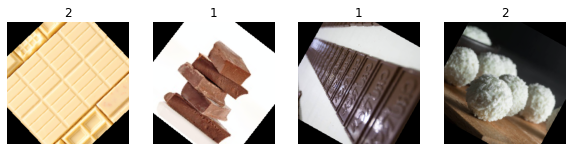

In [6]:
# obtain one batch of training images
data_iter = iter(trainLoader)
images, labels = next(data_iter)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 
    
#white 2, milk 1, dark 0

In [7]:
import torch.nn as nn
import torchvision.models as models

model = models.googlenet(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

if train_on_gpu:
    model.cuda()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [8]:
import torch.optim as optim

# specify loss function (negative log likelihood loss)
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model.parameters(), lr=0.0003)
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [9]:

numEpochs = 30

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store losses
train_losses, val_losses = [], []

for epoch in range(numEpochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    

    # train the model #

    model.train()
    for data, target in trainLoader:
      # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        #clear grad, get predicted outputs, cal loss,
        #cal grad of loss, optimisation step, update training loss
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        


 
    # evaluation of the model #

    model.eval()
    for data, target in valLoader:
      if train_on_gpu:
            data, target = data.cuda(), target.cuda()

      
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)


        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainLoader.sampler)
    valid_loss = valid_loss/len(valLoader.sampler)

    # store the training and validation losses
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'google_model_fine_tune_final.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/google_model_fine_tune_final.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.155127 	Validation Loss: 1.162754
Validation loss decreased (inf --> 1.162754).  Saving model ...
Epoch: 2 	Training Loss: 1.068422 	Validation Loss: 1.102219
Validation loss decreased (1.162754 --> 1.102219).  Saving model ...
Epoch: 3 	Training Loss: 1.020126 	Validation Loss: 1.005759
Validation loss decreased (1.102219 --> 1.005759).  Saving model ...
Epoch: 4 	Training Loss: 0.931020 	Validation Loss: 0.942357
Validation loss decreased (1.005759 --> 0.942357).  Saving model ...
Epoch: 5 	Training Loss: 0.837074 	Validation Loss: 0.891180
Validation loss decreased (0.942357 --> 0.891180).  Saving model ...
Epoch: 6 	Training Loss: 0.787420 	Validation Loss: 0.823394
Validation loss decreased (0.891180 --> 0.823394).  Saving model ...
Epoch: 7 	Training Loss: 0.750460 	Validation Loss: 0.755588
Validation loss decreased (0.823394 --> 0.755588).  Saving model ...
Epoch: 8 	Training Loss: 0.699887 	Validation Loss: 0.716628
Validation loss decreased (0.75558

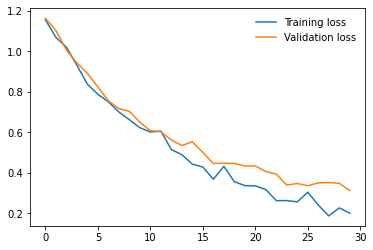

In [10]:
# visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [11]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('google_model_fine_tune_final.pt'))

<All keys matched successfully>

In [12]:
# Test the Trained Network

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in testLoader:

    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testLoader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.281696

Test Accuracy of     0: 81% ( 9/11)
Test Accuracy of     1: 100% (13/13)
Test Accuracy of     2: 83% (10/12)

Test Accuracy (Overall): 88% (32/36)


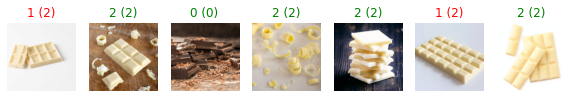

In [13]:
# Visualize Sample Test Results
    
dataiter = iter(testLoader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,7), ncols=7)
for ii in range(7):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 

# 0 is dark, 1 is milk 2 is white